In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL/Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DL/Project


In [7]:
!pip install -U adapters transformers datasets evaluate accelerate scikit-learn -q

In [13]:
import torch
import numpy as np
import os
import json
import logging
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from adapters import AutoAdapterModel, SeqBnConfig

# ================= 0. 静音 Warning =================
logging.getLogger("adapters.model_mixin").setLevel(logging.ERROR)

# --- Configuration ---
MODEL_ID = "gpt2"
ADAPTER_NAME = "sst-2"
REDUCTION_FACTOR = 16
LR = 1e-4
EPOCHS = 5
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "/content/drive/MyDrive/DL_Project/Adapter_SST2_Final"

print(f"Device: {DEVICE}")

# ================= 1. Model Setup =================
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoAdapterModel.from_pretrained(MODEL_ID)
model.config.pad_token_id = tokenizer.pad_token_id

# Adapter + Head
config = SeqBnConfig(reduction_factor=REDUCTION_FACTOR)
model.add_adapter(ADAPTER_NAME, config=config)
model.add_classification_head(ADAPTER_NAME, num_labels=2)

# Activate
model.set_active_adapters(ADAPTER_NAME)
model.train_adapter(ADAPTER_NAME)
model.to(DEVICE)

# Params
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Params: {trainable_params}")

# ================= 2. Data Preparation =================
dataset = load_dataset("glue", "sst2")

def preprocess(examples):
    return tokenizer(
        examples["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

encoded_dataset = dataset.map(preprocess, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# ================= 3. Metrics =================
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}

# ================= 4. Training =================
training_args = TrainingArguments(
    output_dir="./temp_adapter_output",
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    report_to="none",
    remove_unused_columns=False,
    label_names=["labels"]
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("\nStarting Training...")
train_result = trainer.train()

# ================= 5. Results & Debugging =================
print("Evaluating...")
eval_metrics = trainer.evaluate()

print(f"Available metrics: {eval_metrics.keys()}")
final_acc = eval_metrics.get("eval_accuracy", 0.0)
final_f1 = eval_metrics.get("eval_f1", 0.0)
final_loss = eval_metrics.get("eval_loss", 0.0)

results = {
    "Method": "Adapter Tuning",
    "Dataset": "SST-2",
    "Trainable Params": trainable_params,
    "Train Loss": train_result.training_loss,
    "Accuracy": final_acc,
    "F1 Score": final_f1
}

# Save
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
with open(os.path.join(OUTPUT_DIR, "results.json"), "w") as f:
    json.dump(results, f, indent=4)
model.save_adapter(OUTPUT_DIR, ADAPTER_NAME)

print("\n" + "="*60)
print(f"{'METRIC':<25} | {'VALUE':<15}")
print("-" * 43)
print(f"{'Trainable Params':<25} | {results['Trainable Params']:,}")
print(f"{'Train Loss':<25} | {results['Train Loss']:.4f}")
print(f"{'Accuracy':<25} | {results['Accuracy']:.4f}")
print(f"{'F1 Score':<25} | {results['F1 Score']:.4f}")
print("="*60)
print(f"Saved to {OUTPUT_DIR}")

Device: cuda
Trainable Params: 1486658


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]


Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.323000,0.233001,0.912844,0.914221
2,0.264200,0.245588,0.911697,0.914917
3,0.227300,0.235819,0.922018,0.921296
4,0.233200,0.236423,0.922018,0.923251
5,0.184700,0.243604,0.925459,0.927374


Evaluating...


Available metrics: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])

METRIC                    | VALUE          
-------------------------------------------
Trainable Params          | 1,486,658
Train Loss                | 0.2510
Accuracy                  | 0.9255
F1 Score                  | 0.9274
Saved to /content/drive/MyDrive/DL_Project/Adapter_SST2_Final


Plot saved to: /content/drive/MyDrive/DL_Project/Adapter_SST2_Final/training_curves.png


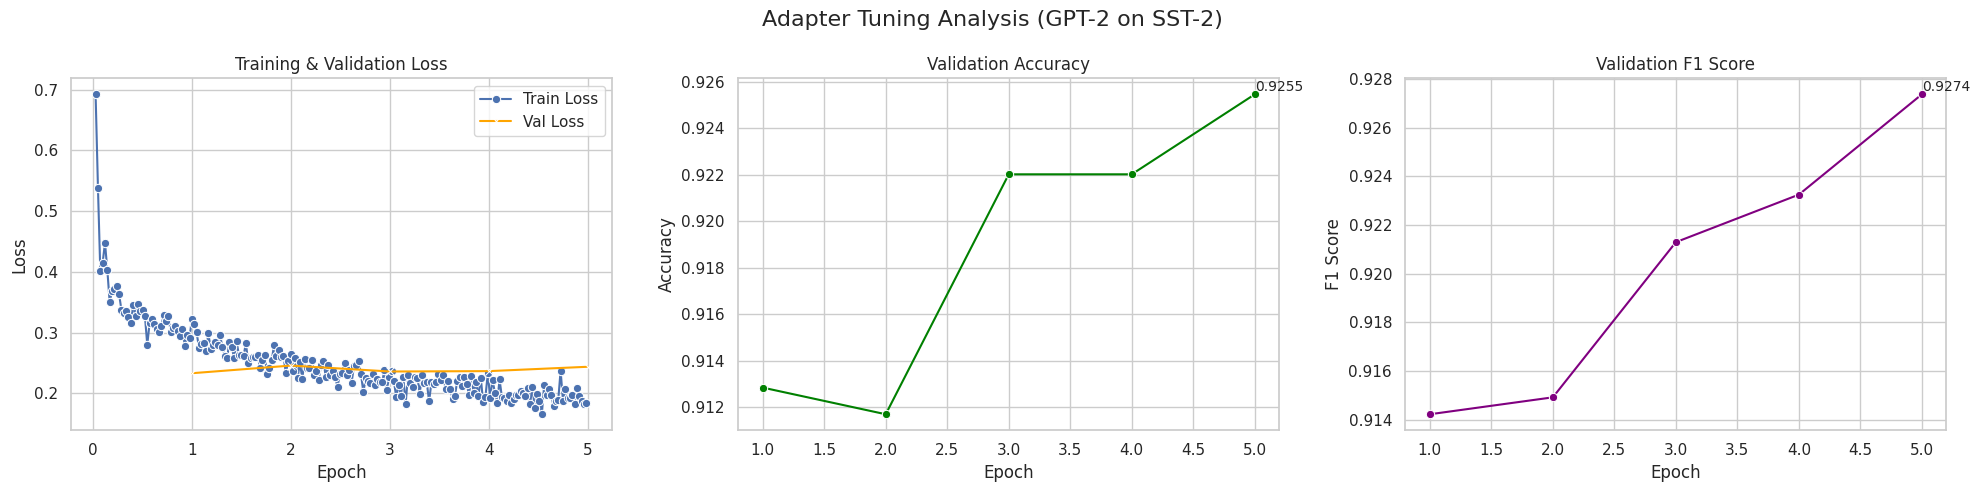

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- Configuration for Plotting ---
OUTPUT_DIR = "/content/drive/MyDrive/DL_Project/Adapter_SST2_Final"
sns.set(style="whitegrid")  # Set style

def plot_metrics(trainer):
    # 1. Extract logs
    history = trainer.state.log_history

    # Separate training loss and evaluation metrics
    train_log = []
    eval_log = []

    for entry in history:
        if 'loss' in entry:
            # Training log entry
            train_log.append({
                'epoch': entry['epoch'],
                'step': entry['step'],
                'loss': entry['loss']
            })
        elif 'eval_accuracy' in entry:
            # Evaluation log entry
            eval_log.append({
                'epoch': entry['epoch'],
                'step': entry['step'],
                'accuracy': entry['eval_accuracy'],
                'f1': entry['eval_f1'],
                'eval_loss': entry.get('eval_loss', None)
            })

    # Convert to DataFrames
    df_train = pd.DataFrame(train_log)
    df_eval = pd.DataFrame(eval_log)

    if df_train.empty or df_eval.empty:
        print("No sufficient logs found to plot. Did training finish?")
        return

    # 2. Create Plot (1 Row, 3 Columns)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Adapter Tuning Analysis (GPT-2 on SST-2)', fontsize=16)

    # --- Plot 1: Training Loss ---
    sns.lineplot(ax=axes[0], data=df_train, x='epoch', y='loss', marker='o', label='Train Loss')
    # Also plot Eval Loss if available
    if 'eval_loss' in df_eval.columns:
        sns.lineplot(ax=axes[0], data=df_eval, x='epoch', y='eval_loss', marker='x', color='orange', label='Val Loss')

    axes[0].set_title('Training & Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # --- Plot 2: Validation Accuracy ---
    sns.lineplot(ax=axes[1], data=df_eval, x='epoch', y='accuracy', marker='o', color='green')
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')

    # Add text annotation for the final point
    last_acc = df_eval.iloc[-1]['accuracy']
    axes[1].text(df_eval.iloc[-1]['epoch'], last_acc, f'{last_acc:.4f}',
                 fontsize=10, verticalalignment='bottom')

    # --- Plot 3: Validation F1 Score ---
    sns.lineplot(ax=axes[2], data=df_eval, x='epoch', y='f1', marker='o', color='purple')
    axes[2].set_title('Validation F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')

    # Add text annotation for the final point
    last_f1 = df_eval.iloc[-1]['f1']
    axes[2].text(df_eval.iloc[-1]['epoch'], last_f1, f'{last_f1:.4f}',
                 fontsize=10, verticalalignment='bottom')

    plt.tight_layout()

    # 3. Save to Drive
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
    save_path = os.path.join(OUTPUT_DIR, "training_curves.png")
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to: {save_path}")
    plt.show()

# Run the plotting function
# Requires the 'trainer' object from the previous step
try:
    plot_metrics(trainer)
except NameError:
    print("Error: 'trainer' object not found. Please run the training cell first.")